**<h2>OPTIMIZING PUBLIC TRANSPORT IN NSW VIA DEMAND PREDICTION AND CLUSTERING<h2>**

**CONTEXT**

In this project, we aim to optimize public transportation services by understanding user behavior across different locations and times. Effective public transport management is crucial for reducing congestion, improving citizen satisfaction, and ensuring the efficient use of resources.

**BUSINESS PROBLEM**

The primary business problem here is to predict the demand for public transportation (measured as count of users) at various locations and times. Accurate demand prediction allows for better resource allocation, such as adjusting bus schedules, optimizing routes, and improving service quality. 

**0.DATA DICTIONARY**

This dataset provides counts of tap ons and tap offs made on the Opal ticketing system during two non-consecutive weeks in 2016. The Opal tap on and tap off dataset contains six CSV files covering two weeks (14 days) of Opal data across the four public transport modes(bus, train, lightrail and ferry).

There are three CSV files per week, and these provide a privacy-protected count of taps against:

Location– by tap (tap on or tap off), by date and by mode

Time with location – binned to 15 minutes, by tap (tap on or tap off), by date and by mode

The tap on and tap off counts are not linked and individual trips cannot be derived using the data.

The two weeks of Opal data are:

25 July to 31 July 2016 (before paper ticket retirement – paper ticket data is not included in the dataset)

8 August to 14 August 2016 (after paper ticket retirement). 

**1.DATA PRE PROCESSING AND EXPLORATORY DATA ANALYSIS(EDA)**

In [67]:
# importing all the required modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score,mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, GradientBoostingClassifier
%matplotlib inline

In [3]:
filepath1 = '/Users/tresornoel/Desktop/IOD/OPAL TAP ON AND OFF/week 1_a.csv'
filepath2 = '/Users/tresornoel/Desktop/IOD/OPAL TAP ON AND OFF/week 1_b.csv'
filepath3 = '/Users/tresornoel/Desktop/IOD/OPAL TAP ON AND OFF/week 1_c.csv'
filepath4 = '/Users/tresornoel/Desktop/IOD/OPAL TAP ON AND OFF/week 2_a.csv'
filepath5 = '/Users/tresornoel/Desktop/IOD/OPAL TAP ON AND OFF/week 2_b.csv'
filepath6 = '/Users/tresornoel/Desktop/IOD/OPAL TAP ON AND OFF/week 2_c.csv'
week1_a = pd.read_csv(filepath1)
week1_b = pd.read_csv(filepath2)
week1_c = pd.read_csv(filepath3)
week2_a = pd.read_csv(filepath4)
week2_b = pd.read_csv(filepath5)
week2_c = pd.read_csv(filepath6)
print(f'WEEK1_A :{week1_a.head()}')
print(f'WEEK1_B :{week1_a.head()}')
print(f'WEEK1_C :{week1_a.head()}')
print(f'WEEK2_A :{week1_a.head()}')
print(f'WEEK2_B :{week1_a.head()}')
print(f'WEEK2_C :{week1_a.head()}')

WEEK1_A :   _id mode      date tap   loc  count
0    1  bus  20160728  on  2095   4540
1    2  bus  20160728  on  2094    498
2    3  bus  20160728  on  2097   2112
3    4  bus  20160728  on  2096   1444
4    5  bus  20160728  on  2090   3684
WEEK1_B :   _id mode      date tap   loc  count
0    1  bus  20160728  on  2095   4540
1    2  bus  20160728  on  2094    498
2    3  bus  20160728  on  2097   2112
3    4  bus  20160728  on  2096   1444
4    5  bus  20160728  on  2090   3684
WEEK1_C :   _id mode      date tap   loc  count
0    1  bus  20160728  on  2095   4540
1    2  bus  20160728  on  2094    498
2    3  bus  20160728  on  2097   2112
3    4  bus  20160728  on  2096   1444
4    5  bus  20160728  on  2090   3684
WEEK2_A :   _id mode      date tap   loc  count
0    1  bus  20160728  on  2095   4540
1    2  bus  20160728  on  2094    498
2    3  bus  20160728  on  2097   2112
3    4  bus  20160728  on  2096   1444
4    5  bus  20160728  on  2090   3684
WEEK2_B :   _id mode      da

In [4]:
week1_b.head()

,_id,mode,date,tap,time,count
0,1,bus,20160728,on,02:30,210
1,2,bus,20160728,on,13:30,10416
2,3,bus,20160728,on,15:15,28887
3,4,bus,20160728,on,12:45,9895
4,5,bus,20160728,on,00:00,553


In [5]:
print(week1_a.columns)
print(week1_b.columns)
print(week1_c.columns)

Index(['_id', 'mode', 'date', 'tap', 'loc', 'count'], dtype='object')
Index(['_id', 'mode', 'date', 'tap', 'time', 'count'], dtype='object')
Index(['_id', 'mode', 'date', 'tap', 'time', 'loc', 'count'], dtype='object')


In [6]:
# Merging Week 1 datasets
week1 = pd.merge(week1_a, week1_b, how='outer', on=['_id', 'mode', 'date', 'tap', 'count'])
week1 = pd.merge(week1, week1_c, how='outer', on=['_id', 'mode', 'date', 'tap', 'count'])

# Merging Week 2 datasets
week2 = pd.merge(week2_a, week2_b, how='outer', on=['_id', 'mode', 'date', 'tap', 'count'])
week2 = pd.merge(week2, week2_c, how='outer', on=['_id', 'mode', 'date', 'tap', 'count'])

In [7]:
# Concatenating week 1 and week 2 datasets
df = pd.concat([week1, week2], axis=0).reset_index(drop=True)

In [8]:
df.head()

,_id,mode,date,tap,loc_x,count,time_x,time_y,loc_y
0,1,bus,20160728,on,2095.0,4540,NaN,NaN,NaN
1,2,bus,20160728,on,2094.0,498,NaN,NaN,NaN
2,3,bus,20160728,on,2097.0,2112,NaN,NaN,NaN
3,4,bus,20160728,on,2096.0,1444,NaN,NaN,NaN
4,5,bus,20160728,on,2090.0,3684,NaN,NaN,NaN


In [9]:
# Combine 'loc_x' and 'loc_y' into a single 'loc' column
df['loc'] = df['loc_x'].fillna(df['loc_y'])

# Combine 'time_x' and 'time_y' into a single 'time' column
df['time'] = df['time_x'].fillna(df['time_y'])

# Drop the extra columns now that we have combined them
df = df.drop(columns=['loc_x', 'loc_y', 'time_x', 'time_y'])


In [10]:
df.head()

,_id,mode,date,tap,count,loc,time
0,1,bus,20160728,on,4540,2095.0,NaN
1,2,bus,20160728,on,498,2094.0,NaN
2,3,bus,20160728,on,2112,2097.0,NaN
3,4,bus,20160728,on,1444,2096.0,NaN
4,5,bus,20160728,on,3684,2090.0,NaN


In [11]:
df.shape

(229714, 7)

In [12]:
# dataset infos

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229714 entries, 0 to 229713
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   _id     229714 non-null  int64  
 1   mode    229714 non-null  object 
 2   date    229714 non-null  int64  
 3   tap     229714 non-null  object 
 4   count   229714 non-null  int64  
 5   loc     220500 non-null  float64
 6   time    221714 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 12.3+ MB


In [13]:
# checking missing values

df.isnull().sum()

_id         0
mode        0
date        0
tap         0
count       0
loc      9214
time     8000
dtype: int64

In [14]:
# statistical summary

df.describe().T

,count,mean,std,min,25%,50%,75%,max
_id,229714.0,4.931334e+04,32422.153570,1.0,20108.0,48822.0,77536.0,107500.0
date,229714.0,2.016077e+07,41.523471,20160725.0,20160728.0,20160808.0,20160811.0,20160814.0
count,229714.0,4.064210e+02,2598.274530,18.0,29.0,52.0,110.0,147900.0
loc,220500.0,2.157991e+03,259.363578,-1.0,2042.0,2122.0,2208.0,2785.0


**1.1.converting the date type**

In [15]:
# Convert the 'date' column from integer to datetime type
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# Check the first few rows to confirm the conversion
print(df[['date']].dtypes)

date    datetime64[ns]
dtype: object


**1.2.Filling the missing values in 'time' column**

all the missing values in 'time' column are in bus mode so i used the mode to fill the missing values , because the buses usually follow a schedule with certain peak times.

In [16]:
# Calculate the mode of 'time' for bus mode
bus_time_mode = df[df['mode'] == 'bus']['time'].mode()[0]

# Fill missing 'time' values in bus mode with the mode of bus 
df.loc[(df['mode'] == 'bus') & (df['time'].isna()), 'time'] = bus_time_mode

**1.3.Filling the missing values in 'loc' column**

Most public transport follows certain patterns. Buses or trains tend to stop at specific locations during certain times of the day. By grouping based on mode, i use these patterns to make imputations

In [17]:
# Calculate the overall mode for the 'loc' column in the dataset
loc_mode = df['loc'].mode()[0]

# Fill any remaining missing 'loc' values with the mode
df['loc'].fillna(loc_mode, inplace=True)

# Check how many missing values 
print(df['loc'].isna().sum())

0


**1.4.Handling invalid value -1 in the 'loc' column**

The column 'loc' has some invalid values -1 , i decided to impute using overall mode for bus because all the invalid location -1 corresponding to the bus mode of transport

In [18]:
# Filter the row where location is -1
invalid_location_row = df[df['loc'] == -1]
# Display the row with location -1
print(invalid_location_row)


         _id mode       date  tap  count  loc   time
57        58  bus 2016-07-28   on  12465 -1.0  15:15
366      367  bus 2016-07-28  off  66539 -1.0  15:15
666      667  bus 2016-07-30   on   7071 -1.0  15:15
936      937  bus 2016-07-30  off  21845 -1.0  15:15
1210    1211  bus 2016-07-29   on  12077 -1.0  15:15
...      ...  ...        ...  ...    ...  ...    ...
228420  2707  bus 2016-08-11  off  66440 -1.0  15:15
228725  3012  bus 2016-08-12   on    514 -1.0  15:15
229033  3320  bus 2016-08-12  off  60949 -1.0  15:15
229335  3622  bus 2016-08-13   on    337 -1.0  15:15
229605  3892  bus 2016-08-13  off  18447 -1.0  15:15

[1552 rows x 7 columns]


In [19]:

# Find the most common location (mode) for the bus mode of transport
bus_mode_loc = df[df['mode'] == 'bus']['loc'].mode()[0]

# Replace invalid locations (-1) for bus mode with the most common bus location
df.loc[(df['loc'] == -1) & (df['mode'] == 'bus'), 'loc'] = bus_mode_loc

# Check if the -1 values have been replaced
print(df[df['loc'] == -1])

Empty DataFrame
Columns: [_id, mode, date, tap, count, loc, time]
Index: []


**1.5.Handling invalid value -1 in the 'time' column**

In [20]:
# Calculate the mode of the time column (excluding -1)
time_mode = df[df['time'] != '-1']['time'].mode()[0]

# Replace the -1 values with the mode
df['time'] = df['time'].replace('-1', time_mode)

# Verify that there are no more -1 values
print(df['time'].value_counts())

time
15:15    13584
15:30     5357
08:15     5216
15:00     5151
08:30     5122
         ...  
02:00       81
02:45       78
03:15       77
03:45       74
03:00       73
Name: count, Length: 96, dtype: int64


In [21]:
# Display the cleaned dataframe
df.sample(15)

,_id,mode,date,tap,count,loc,time
59308,50707,bus,2016-07-28,off,128,2021.0,08:00
200354,82141,bus,2016-08-12,on,25,2093.0,14:00
182310,64097,bus,2016-08-11,on,41,2168.0,14:00
177838,59625,bus,2016-08-10,off,87,2042.0,11:00
183171,64958,bus,2016-08-11,on,19,2133.0,16:00
210368,92155,bus,2016-08-12,off,40,2039.0,21:00
60691,52090,bus,2016-07-28,off,39,2160.0,11:00
77226,68625,bus,2016-07-29,off,38,2027.0,17:00
140118,21905,bus,2016-08-08,on,35,2019.0,06:45
187734,69521,bus,2016-08-11,on,19,2165.0,19:30


In [22]:
df.isnull().sum()

_id      0
mode     0
date     0
tap      0
count    0
loc      0
time     0
dtype: int64

In [23]:
df.duplicated().sum()

0

In [24]:
# convert 'time'column to datetime type
df['time'] = pd.to_datetime(df['time'], format='%H:%M')

**1.6.Mapping the postcodes to their names**

In [25]:
pd.set_option('display.max_rows', None)

#value_counts() to see all the postcodes and their counts
print(df['loc'].value_counts())


loc
2000.0    13442
2010.0     2184
2026.0     2146
2022.0     2135
2031.0     2072
2150.0     2040
2035.0     2027
2042.0     1998
2033.0     1996
2032.0     1985
2050.0     1978
2148.0     1880
2037.0     1861
2089.0     1858
2099.0     1857
2020.0     1850
2021.0     1844
2007.0     1822
2088.0     1817
2034.0     1799
2204.0     1796
2134.0     1790
2065.0     1787
2113.0     1786
2017.0     1782
2100.0     1764
2170.0     1762
2216.0     1753
2067.0     1743
2040.0     1734
2112.0     1725
2135.0     1724
2066.0     1701
2154.0     1696
2018.0     1694
2770.0     1686
2008.0     1683
2039.0     1673
2560.0     1666
2122.0     1661
2095.0     1644
2060.0     1643
2200.0     1636
2153.0     1634
2220.0     1618
2194.0     1616
2047.0     1612
2145.0     1611
2016.0     1606
2155.0     1548
2250.0     1542
2036.0     1523
2165.0     1517
2093.0     1506
2024.0     1493
2046.0     1472
2176.0     1460
2131.0     1447
2121.0     1445
2041.0     1430
2009.0     1423
2750.0     1381
2090

In [26]:
postcode_to_location = {
    2045:'HABERFIELD',2130:'SUMMER HILL',2131: 'ASHFIELD',2132:'CROYDON',2133:'CROYDON PARK',2193:'ASHBURY',2141:'LIDCOMBE',2143:'REGENTS PARK',2144:'AUBURN',2190:'GREENACRE',2195:'LAKEMBA',2196:'ROSELANDS',
    2198:'GEORGES HALL',2200:'BANKSTOWN',2162:'CHESTER HILL',2197:'BASS HILL',2199:'YAGOONA',2080:'MOUNT KURING-GAI',2081:'BEROWRA',2082:'BEROWRA CREEK',2780:'KATOOMBA',2782:'WENTWORTH FALLS',2785:'BLACKHEATH',2147:'SEVEN HILLS',2148:'BLACKTOWN',2763:'QUAKERS HILL',2766:'EASTERN CREEK',2767:'DOONSIDE',2768:'GLENWOOD',2769:'THE PONDS',2773:'GLENBROOK',2774:'BLAXLAND',2018:'ROSEBERY',
    2019:'BOTANY',2036:'EASTGARDENS',2133:'ENFIELD SOUTH',2134:'BURWOOD',2136:'ENFIELD',2570:'CAMDEN',2558:'EAGLE VALE',2559:'CLAYMORE',2560:'CAMPBELLTOWN',2563:'MENANGLE PARK',2565:'INGLEBURN',2566:'MINTO',2046:'FIVE DOCK',2047:'DRUMMOYNE',2191:'BELFIELD',2192:'BELMORE',
    2193:'CANTERBURY',2194:'CAMPSIE',2206:'EARLWOOD',2126:'CHERRYBROOK',2155:'KELLYVILLE',2156:'KENTHURST',2157:'GLENORIE',2158:'DURAL',2159:'ARCADIA',2046:'CANADA BAY',2137:'CONCORD',2138:'CONCORD WEST',2211:'PADSTOW',2212:'REVESBY',2213:'EAST HILLS',2214:'MILPERRA',2161:'GUILDFORD',2163:'VILLAWOOD',2164:'WETHERILL PARK',2165:'FAIRFIELD',2166:'LANSVALE',2084:'TERREY HILLS',2085:'BELROSE',2086:'FRENCHS FOREST',2087:'FORESTVILLE',2083:'BAR POINT',2778:'WOODFORD',2779:'HAZELBROOK',2783:'LAWSON',2784:'BULLABURRA',2142:'HOLROYD',2145:'GIRRAWEEN',2148:'PROSPECT',2160:'MERRYLANDS',2076:'NORMANHURST',2077:'HORNSBY',2079:'MOUNT COLAH',2119:'BEECROFT',2120:'PENNANT HILLS',2125:'WEST PENNANT HILLS',2110:'HUNTERS HILL',2111:'HENLEY',2208:'KINGSGROVE',2209:'BEVERLY HILLS',2210:'PEAKHURST',2220:'HURSTVILLE',2221:'SOUTH HURSTVILLE',2222:'PENSHURST',2223:'OATLEY',2217:'KOGARAH',2218:'CARLTON',2220:'HURSTVILLE GROVE',2221:'BLAKEHURST',2223:'MORTDALE',2069:'ROSEVILLE',2070:'LINDFIELD',2071:'KILLARA',2072:'GORDON',2073:'PYMBLE',2074:'TURRAMURRA',2075:'ST IVES',2076:'WAHROONGA',2758:'KURRAJONG',2775:'SINGLETONS MILL',2066:'LANE COVE',2038:'ANNANDALE',2039:'ROZELLE',2040:'LEICHHARDT',2041:'BALMAIN',2048:'WESTGATE',2166:'CABRAMATTA',2167:'GLENFIELD',2168:'ASHCROFT',2170:'CASULA',2171:'HOXTON PARK',2173:'HOLSWORTHY',2174:'EDMONDSON PARK',2176:'GREENFIELD PARK',2177:'BONNYRIGG',2179:'LEPPINGTON',2564:'MACQUARIE FIELDS',2092:'SEAFORTH',2093:'BALGOWLAH',2094:'FAIRLIGHT',2095:'MANLY',2096:'QUEENSCLIFF',2097:'COLLAROY',2099:'DEE WHY',2100:'BROOKVALE',2101:'NARRABEEN',2102:'WARRIEWOOD',2103:'MONA VALE',2104:'BAYVIEW',2105:'CHURCH POINT',2106:'NEWPORT',2107:'AVALON',2108:'PALM BEACH',2042:'NEWTOWN',2044:'SYDENHAM',2048:'STANMORE',2049:'LEWISHAM',2049:'PETERSHAM',2050:'CAMPERDOWN',2203:'DULWICH HILL',2204:'MARRICKVILLE',2088:'MOSMAN',2089:'NEUTRAL BAY',2090:'CREMORNE',2557:'GREGORY HILLS',2567:'CURRANS HILL',2567:'NARELLAN',2745:'GREENDALE',2127:'SYDNEY OLYMPIC PARK',2128:'SILVERWATER',2115:'ERMINGTON',2116:'RYDALMERE',2117:'OATLANDS',2118:'CARLINGFORD',2142:'GRANVILLE',2145:'WESTMEAD',2146:'TOONGABBIE',2150:'PARRAMATTA',2151:'NORTH PARRAMATTA',2152:'NORTHMEAD',2153:'BAULKHAM HILLS',2154:'CASTLE HILL',2745:'GLENMORE PARK',2747:'KINGSWOOD',2750:'EMU PLAINS',2752:'SILVERDALE',2031:'RANDWICK',2032:'KINGSFORD',2033:'KENSINGTON',2034:'COOGEE',2035:'MAROUBRA',2036:'MATRAVILLE',2137:'BREAKFAST POINT',2138:'RHODES',2753:'RICHMOND',2754:'NORTH RICHMOND',2756:'WINDSOR',2765:'BOX HILL',2205:'WOLLI CREEK',2206:'CLEMTON PARK',2207:'BEXLEY',2216:'ROCKDALE',2217:'RAMSGATE',2219:'SANDRINGHAM',2111:'GLADESVILLE',2113:'MACQUARIE PARK',2114:'MEADOWBANK',2121:'EPPING',2122:'EASTWOOD',2776:'FAULCONBRIDGE',2777:'SPRINGWOOD',2747:'SHANES PARK',2748:'ORCHARD HILLS',2759:'ERSKINE PARK',2760:'ST MARYS',2761:'OAKHURST',2762:'SCHOFIELDS',2763:'ACACIA GARDENS',2766:'ROOTY HILL',2770:'MOUNT DRUITT',2135:'STRATHFIELD',2136:'STRATHFIELD SOUTH',2140:'HOMEBUSH',2224:'SYLVANIA',2225:'OYSTER BAY',2226:'JANNALI',2227:'GYMEA',2228:'MIRANDA',2229:'CARINGBAH',2230:'CRONULLA',2231:'KURNELL',2232:'SUTHERLAND',2233:'ENGADINE',2234:'MENAI',2508:'HELENSBURGH',2020:'SYDNEY AIRPORT',2000: 'SYDNEY',2007:'BROADWAY',2008:'CHIPPENDALE',2009:'PYRMONT',2010:'DARLINGHURST',2011:'WOOLLOOMOOLOO',2015:'ALEXANDRIA',2016:'REDFERN',2017:'WATERLOO',2021:'MOORE PARK',
    2037:'GLEBE',2043:'ERSKINEVILLE',2057:'CHATSWOOD',2060:'MACMAHONS POINT',2061:'KIRRIBILLI',2062:'CAMMERAY',2063:'NORTHBRIDGE',2064:'ARTARMON',2065:'ST LEONARDS',2067:'CHATSWOOD WEST',2068:'MIDDLE COVE',2069:'CASTLE COVE',2027:'EDGECLIFF',2028:'DOUBLE BAY',2029:'ROSE BAY',2030:'VAUCLUSE',2021:'PADDINGTON',2022:'BONDI JUNCTION',2023:'BELLEVUE HILL',2024:'BRONTE',2025:'WOOLLAHRA',2026:'BONDI',2112:'Ryde',2749:'Penrith',2250:'Gosford', 2251:'Erina', 2256:'Woy Woy', 2112: 'Ryde',2749: 'Penrith',2250: 'Gosford',2251: 'Erina',2256: 'Woy Woy',2257: 'Ettalong Beach',2258: 'Ourimbah',2259: 'Wyong',2260: 'Terrigal',2261: 'The Entrance',2262: 'Lake Munmorah',2263: 'Toukley',2264: 'Morisset',2265: 'Cooranbong',2267: 'Cessnock',2278: 'Charlestown',2280: 'Belmont',2281: 'Swansea',2282: 'Warners Bay',2283: 'Toronto',2284: 'Boolaroo',2285: 'Edgeworth',2286: 'Cardiff',2287: 'Jesmond',2289: 'Adamstown',2290: 'Merewether',2291: 'Stockton',2292: 'Newcastle',2293: 'Hamilton',2294: 'Carrington',2295: 'Mayfield',2296: 'Tighes Hill',2297: 'Maryville',2298: 'Islington',2299: 'New Lambton',2300: 'Newcastle',2302: 'Cooks Hill',2303: 'Hamilton East',2304: 'Tighes Hill',2305: 'Lambton',2306: 'Waratah',2307: 'Broadmeadow',2308: 'Callaghan',2315: 'Nelson Bay',2316: 'Shoal Bay',2317: 'Anna Bay',2318: 'Salt Ash',2319: 'Medowie',2320: 'Maitland',2321: 'East Maitland',2322: 'Thornton',2323: 'Rutherford',2324: 'Raymond Terrace',2325: 'Cessnock',2326: 'Kitchener',2327: 'Kurri Kurri',2330: 'Singleton',2334: 'Greta',2335: 'Branxton',2421: 'Dungog',2500: 'Wollongong',2502: 'Coniston',2505: 'Port Kembla',2506: 'Dapto',2515: 'Thirroul',2516: 'Bulli',2517: 'Woonona',2518: 'Corrimal',2519: 'Fairy Meadow',2525: 'Figtree',2526: 'Mount Keira',2527: 'Shellharbour',2528: 'Warilla',2529: 'Shell Cove',2530: 'Dapto',2533: 'Kiama'
}

In [27]:
#apply the dictionary to replace postcodes with location names in the 'loc' column
df['loc'] = df['loc'].replace(postcode_to_location)

# Check if the postcodes have been replaced
print(df[['loc']].head())

           loc
0        MANLY
1    FAIRLIGHT
2     COLLAROY
3  QUEENSCLIFF
4     CREMORNE


In [28]:
df.sample(15)

,_id,mode,date,tap,count,loc,time
69671,61070,bus,2016-07-29,on,49,RANDWICK,1900-01-01 22:00:00
11474,2873,bus,2016-07-30,on,78,MARRICKVILLE,1900-01-01 09:45:00
14377,5776,bus,2016-07-30,off,33,CHATSWOOD WEST,1900-01-01 07:15:00
86386,77785,bus,2016-07-27,on,243,GLEBE,1900-01-01 07:45:00
108178,99577,bus,2016-07-25,off,21,MEADOWBANK,1900-01-01 14:00:00
186754,68541,bus,2016-08-11,on,303,BANKSTOWN,1900-01-01 08:15:00
216376,98163,bus,2016-08-13,on,73,HURSTVILLE GROVE,1900-01-01 10:45:00
213084,94871,bus,2016-08-12,off,81,STRATHFIELD,1900-01-01 10:00:00
102541,93940,bus,2016-07-25,on,31,RYDALMERE,1900-01-01 08:00:00
151743,33530,bus,2016-08-08,off,180,ST IVES,1900-01-01 08:15:00


In [29]:
# Convert 'time' column to datetime format 
df['time'] = pd.to_datetime(df['time'])
# Extract only the time (hours, minutes, seconds)
df['time'] = df['time'].dt.time

In [30]:
df.head()

,_id,mode,date,tap,count,loc,time
0,1,bus,2016-07-28,on,4540,MANLY,15:15:00
1,2,bus,2016-07-28,on,498,FAIRLIGHT,15:15:00
2,3,bus,2016-07-28,on,2112,COLLAROY,15:15:00
3,4,bus,2016-07-28,on,1444,QUEENSCLIFF,15:15:00
4,5,bus,2016-07-28,on,3684,CREMORNE,15:15:00


In [31]:
print(df['time'].dtype)
print(df['time'].head())

object
0    15:15:00
1    15:15:00
2    15:15:00
3    15:15:00
4    15:15:00
Name: time, dtype: object


In [32]:
print(df['time'].apply(type).value_counts())

time
<class 'datetime.time'>    229714
Name: count, dtype: int64


In [33]:
from datetime import datetime, time  

# Apply the conversion only to string objects
df['time'] = df['time'].apply(lambda x: x if isinstance(x, time) else datetime.strptime(x, '%H:%M:%S').time())

# Verify the result
print(df['time'].apply(type).value_counts())  
print(df['time'].head())

time
<class 'datetime.time'>    229714
Name: count, dtype: int64
0    15:15:00
1    15:15:00
2    15:15:00
3    15:15:00
4    15:15:00
Name: time, dtype: object


In [34]:
df.isnull().sum()

_id      0
mode     0
date     0
tap      0
count    0
loc      0
time     0
dtype: int64

In [35]:
df.head()

,_id,mode,date,tap,count,loc,time
0,1,bus,2016-07-28,on,4540,MANLY,15:15:00
1,2,bus,2016-07-28,on,498,FAIRLIGHT,15:15:00
2,3,bus,2016-07-28,on,2112,COLLAROY,15:15:00
3,4,bus,2016-07-28,on,1444,QUEENSCLIFF,15:15:00
4,5,bus,2016-07-28,on,3684,CREMORNE,15:15:00


**1.7.Distribution of Tap-On/Off Counts**

/Users/tresornoel/Desktop/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


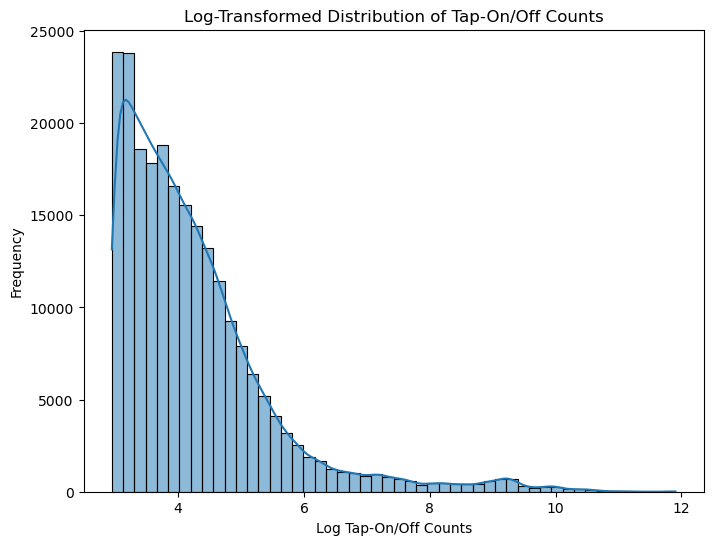

In [36]:
# Log-transform the 'count' column (log1p handles zeros)
log_counts = np.log1p(df['count'])

# Plot the histogram of log-transformed tap counts
plt.figure(figsize=(8, 6))
sns.histplot(log_counts, bins=50, kde=True)
plt.title('Log-Transformed Distribution of Tap-On/Off Counts')
plt.xlabel('Log Tap-On/Off Counts')
plt.ylabel('Frequency')
plt.show()

**1.8.Mode of Transport analysis**

the purpose is to compare the total tap-on/off counts by mode of transport (bus, train, ferry, light rail)

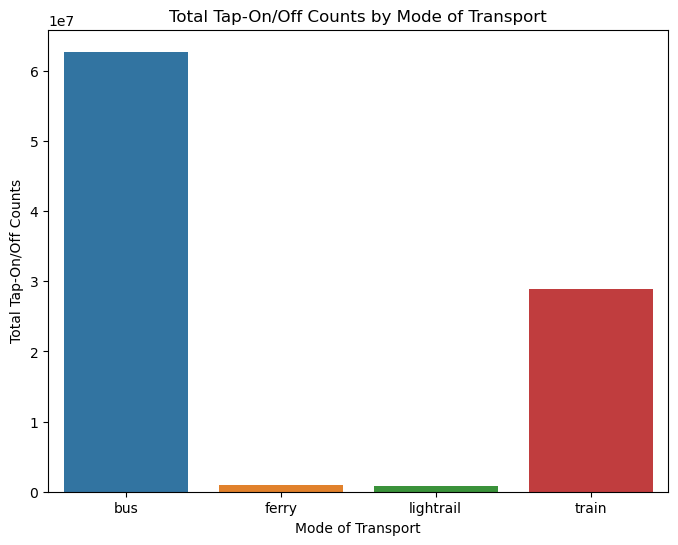

In [37]:
# Total tap-on/off counts by mode of transport
mode_counts = df.groupby('mode')['count'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='mode', y='count', data=mode_counts)
plt.title('Total Tap-On/Off Counts by Mode of Transport')
plt.xlabel('Mode of Transport')
plt.ylabel('Total Tap-On/Off Counts')
plt.show()

the bus is the most used mode of transport followed by train ,ferry and lightrail are not as common as buses and trains

**1.9.Location analysis**

the goal is to Identify the most frequented locations based on tap-on/off counts.

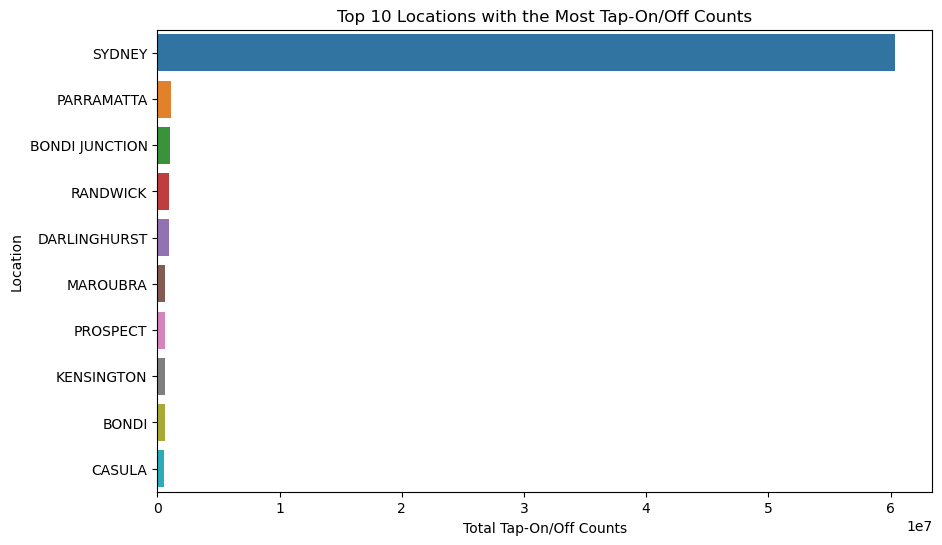

In [38]:
# Group by location to get total tap counts per location
location_counts = df.groupby('loc')['count'].sum().reset_index().sort_values(by='count', ascending=False)

# Plot the top 10 locations
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='loc', data=location_counts.head(10))
plt.title('Top 10 Locations with the Most Tap-On/Off Counts')
plt.xlabel('Total Tap-On/Off Counts')
plt.ylabel('Location')
plt.show()

by analysing the top 10 locations with the most tap ons/ offs we can see that sydney city has most the most followed by paramatta 

In [39]:
# Top 5 locations
top_5_locations = location_counts.head(5)
print("Top 5 Locations:\n", top_5_locations)

# Bottom 5 locations
bottom_5_locations = location_counts.tail(5)
print("Bottom 5 Locations:\n", bottom_5_locations)

Top 5 Locations:
                 loc     count
262          SYDNEY  60383049
216      PARRAMATTA   1086444
31   BONDI JUNCTION   1045804
228        RANDWICK    994774
82     DARLINGHURST    972108
Bottom 5 Locations:
                   loc  count
140          Hamilton    683
188  MOUNT KURING-GAI    345
90             Dungog    220
39         BULLABURRA     46
251   SINGLETONS MILL     18


In [40]:
print(df['time'].dtype)

object


**1.10.Time of Day Analysis**

the purpose of this analysis is to understand the busiest time of the day for tap ons and tap offs.

/Users/tresornoel/Desktop/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tresornoel/Desktop/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


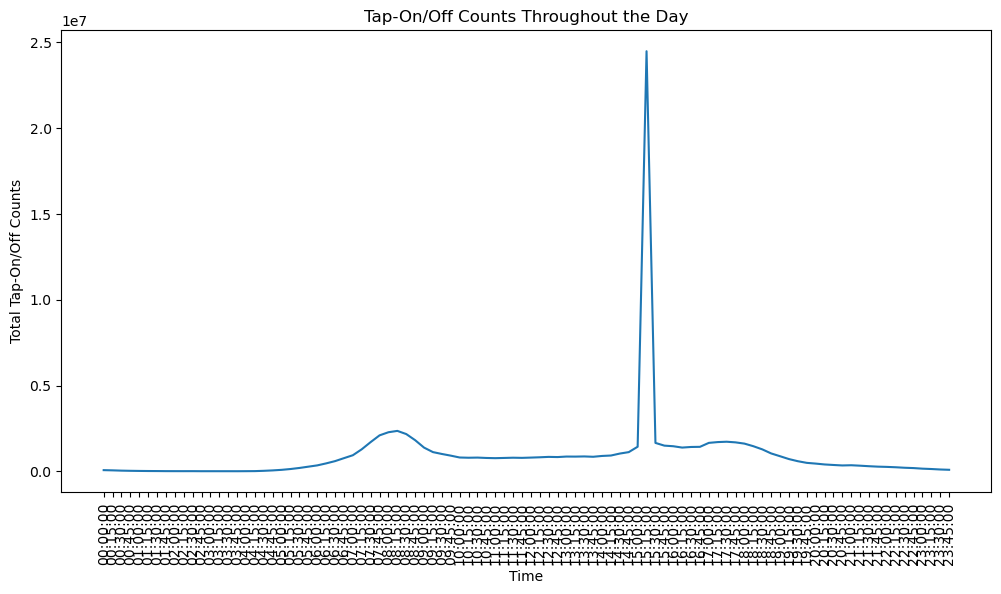

In [41]:
# Assuming 'df' is your original DataFrame
time_counts = df.groupby('time')['count'].sum().reset_index()
# Convert time to string format
time_counts['time'] = time_counts['time'].astype(str)

# Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='count', data=time_counts)
plt.title('Tap-On/Off Counts Throughout the Day')
plt.xlabel('Time')
plt.ylabel('Total Tap-On/Off Counts')
plt.xticks(rotation=90)
plt.show()





not too clear but by having a closer look we can see that the peak hour for tap ons and tap offs are between 3 pm and 3.45 pm

**1.11.Tap-On vs Tap-Off Counts**

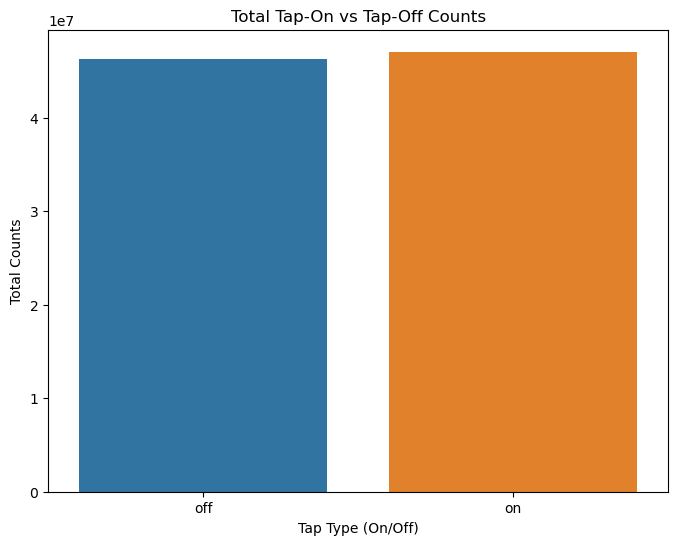

In [42]:
# Group by tap (on/off) to get total counts
tap_counts = df.groupby('tap')['count'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='tap', y='count', data=tap_counts)
plt.title('Total Tap-On vs Tap-Off Counts')
plt.xlabel('Tap Type (On/Off)')
plt.ylabel('Total Counts')
plt.show()

**Add the 'paper ticket status' column to the dataset**

we will create the 'paper ticket status' based on date the last day for paper ticket was on 31-07-2016; 0 for 'before retirement' and 1 for 'after retirement'

In [43]:
# Create a flag for before/after paper ticket retirement (0 for before, 1 for after)
df['paper_ticket_status'] = df['date'].apply(lambda x: 0 if x <= pd.to_datetime('2016-07-31') else 1)

# check the dataset
print(df.head())

   _id mode       date tap  count          loc      time  paper_ticket_status
0    1  bus 2016-07-28  on   4540        MANLY  15:15:00                    0
1    2  bus 2016-07-28  on    498    FAIRLIGHT  15:15:00                    0
2    3  bus 2016-07-28  on   2112     COLLAROY  15:15:00                    0
3    4  bus 2016-07-28  on   1444  QUEENSCLIFF  15:15:00                    0
4    5  bus 2016-07-28  on   3684     CREMORNE  15:15:00                    0


In [44]:
df.dtypes

_id                             int64
mode                           object
date                   datetime64[ns]
tap                            object
count                           int64
loc                            object
time                           object
paper_ticket_status             int64
dtype: object

**Tap-On/Off Counts Before and After Paper Ticket Retirement**

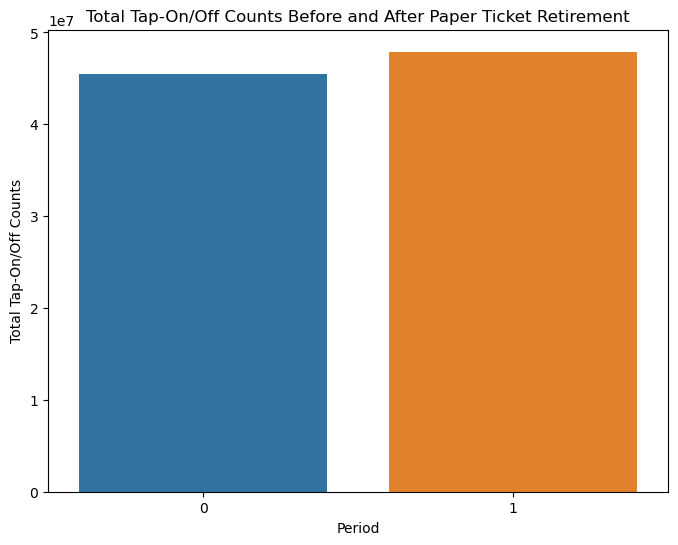

In [45]:
# Group by paper ticket status and calculate mean/total tap-on/off counts
before_after_counts = df.groupby('paper_ticket_status')['count'].sum().reset_index()

# Plot the results
plt.figure(figsize=(8, 6))
sns.barplot(x='paper_ticket_status', y='count', data=before_after_counts)
plt.title('Total Tap-On/Off Counts Before and After Paper Ticket Retirement')
plt.xlabel('Period')
plt.ylabel('Total Tap-On/Off Counts')
plt.show()

**Mode of Transport Usage Before and After Paper Ticket Retirement**

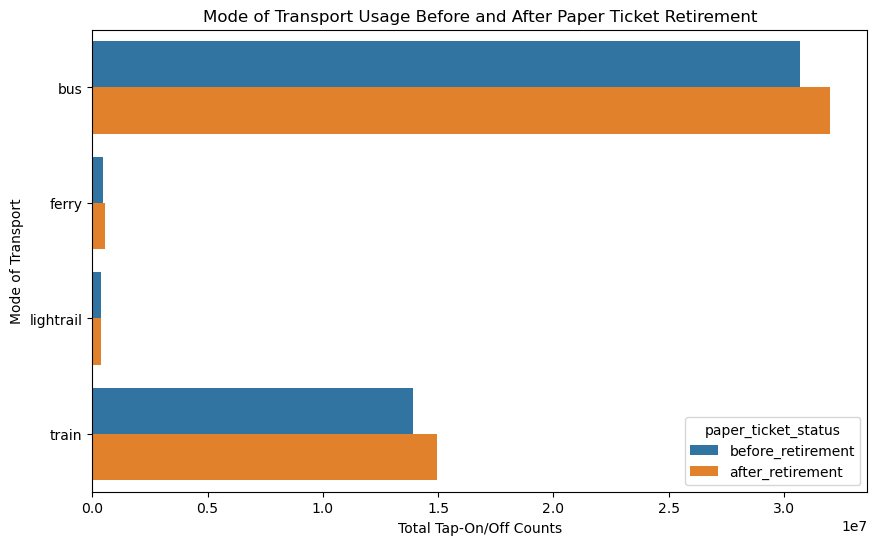

In [46]:
# total Tap-On/Off counts by mode of transport and paper_ticket_status
mode_before_after = df.groupby(['mode', 'paper_ticket_status'])['count'].sum().reset_index()


# Convert paper_ticket_status to string for better readability in hue
mode_before_after['paper_ticket_status'] = mode_before_after['paper_ticket_status'].apply(lambda x: 'before_retirement' if x == 0 else 'after_retirement')

# Plot the results again
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='mode', hue='paper_ticket_status', data=mode_before_after)
plt.title('Mode of Transport Usage Before and After Paper Ticket Retirement')
plt.xlabel('Total Tap-On/Off Counts')
plt.ylabel('Mode of Transport')
plt.show()

**Tap-On/Off Counts by Day of the Week**

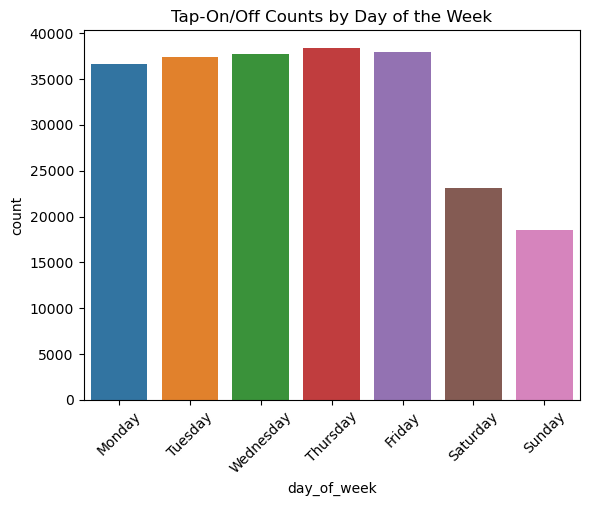

In [47]:
# Extract day of the week
df['day_of_week'] = df['date'].dt.day_name()

# Plot tap-on/off counts by day of the week
sns.countplot(data=df, x='day_of_week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Tap-On/Off Counts by Day of the Week')
plt.xticks(rotation=45)
plt.show()

**Tap-On/Off Counts by Mode**

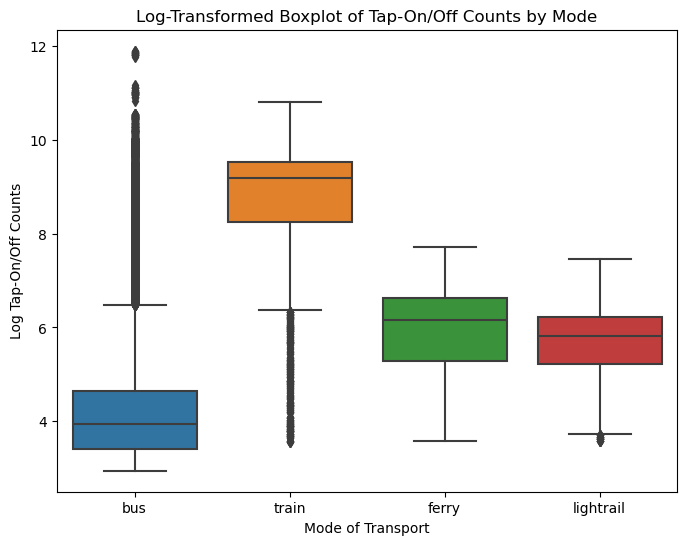

In [48]:
# Plot log-transformed boxplot by mode
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='mode', y=np.log1p(df['count']))
plt.title('Log-Transformed Boxplot of Tap-On/Off Counts by Mode')
plt.xlabel('Mode of Transport')
plt.ylabel('Log Tap-On/Off Counts')
plt.show()

On average, trains have the highest tap counts compared to other modes. The interquartile range for trains is larger, meaning more variability in tap counts across different times or locations. There are also some outliers.<br>

 Buses exhibit a much wider range of tap counts, with a large number of outliers, indicating that some buses (perhaps at peak times or busy routes) see extremely high tap counts compared to others.<br>
 
 Both ferry and light rail have relatively consistent tap counts, with fewer extreme variations. Ferries have slightly higher counts than light rail, but both are lower on average than buses and trains.

In [49]:
df.head()

,_id,mode,date,tap,count,loc,time,paper_ticket_status,day_of_week
0,1,bus,2016-07-28,on,4540,MANLY,15:15:00,0,Thursday
1,2,bus,2016-07-28,on,498,FAIRLIGHT,15:15:00,0,Thursday
2,3,bus,2016-07-28,on,2112,COLLAROY,15:15:00,0,Thursday
3,4,bus,2016-07-28,on,1444,QUEENSCLIFF,15:15:00,0,Thursday
4,5,bus,2016-07-28,on,3684,CREMORNE,15:15:00,0,Thursday


**2.UNSUPERVISED LEARNING**

In [50]:
# Inspect the data
print(df.head())
print(df.info())

   _id mode       date tap  count          loc      time  paper_ticket_status  \
0    1  bus 2016-07-28  on   4540        MANLY  15:15:00                    0   
1    2  bus 2016-07-28  on    498    FAIRLIGHT  15:15:00                    0   
2    3  bus 2016-07-28  on   2112     COLLAROY  15:15:00                    0   
3    4  bus 2016-07-28  on   1444  QUEENSCLIFF  15:15:00                    0   
4    5  bus 2016-07-28  on   3684     CREMORNE  15:15:00                    0   

  day_of_week  
0    Thursday  
1    Thursday  
2    Thursday  
3    Thursday  
4    Thursday  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229714 entries, 0 to 229713
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   _id                  229714 non-null  int64         
 1   mode                 229714 non-null  object        
 2   date                 229714 non-null  datetime64[ns]
 3   tap         

In [51]:
# Frequency encoding the 'loc' feature
loc_frequency = df['loc'].value_counts().to_dict()
df['loc_freq'] = df['loc'].map(loc_frequency)

In [52]:
# Convert time to seconds
df['time_seconds'] = df['time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

In [53]:
# One-hot encoding for categorical variables if needed
df = pd.get_dummies(df, columns=['mode', 'tap', 'day_of_week'], drop_first=True)

# Select relevant features for clustering
clustering_features = df[['loc_freq', 'count', 'time_seconds', 'paper_ticket_status']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

**2.1.Plot the Elbow Method**

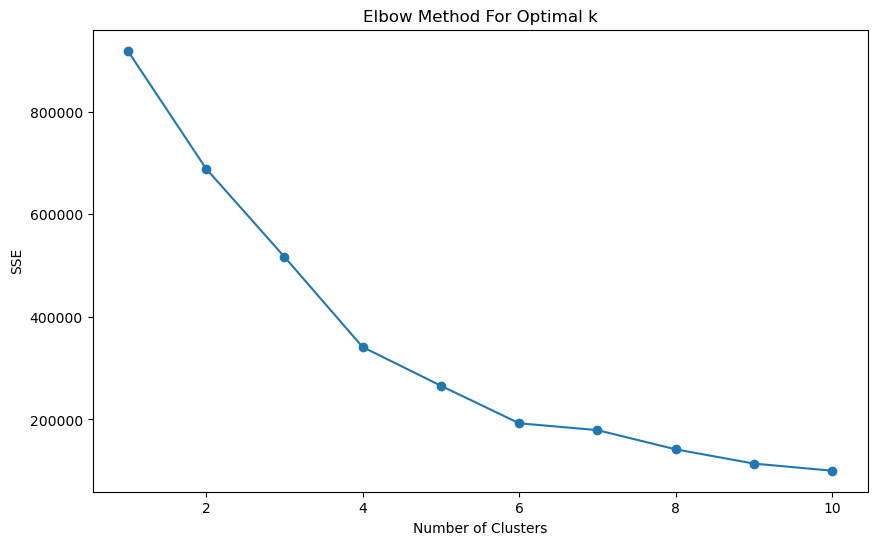

In [54]:
# Determine the optimal number of clusters using the Elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

**2.2.Apply KMeans**

In [55]:
# Apply K-Means clustering with the selected number of clusters (e.g., k=3)
optimal_k = 4  # Choose based on Elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

**2.3.PCA Visualization**

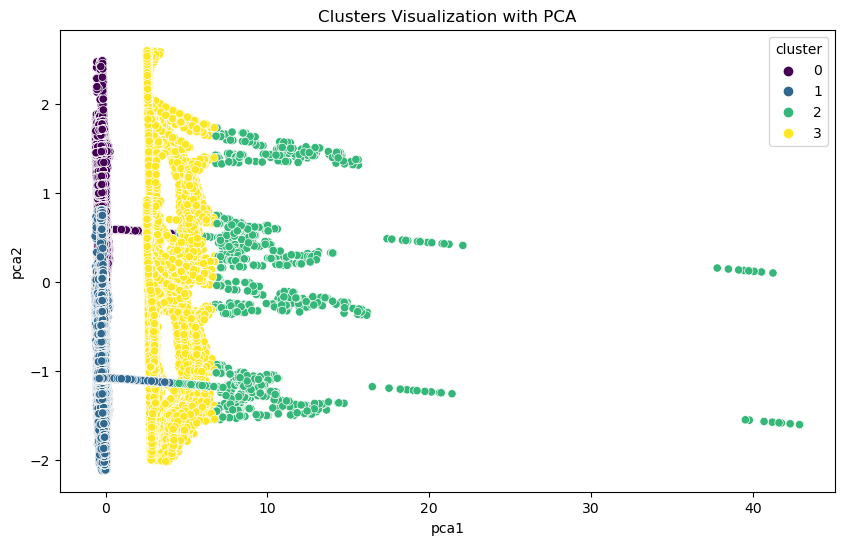

In [59]:
# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
df['pca1'] = principal_components[:, 0]
df['pca2'] = principal_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='viridis')
plt.title('Clusters Visualization with PCA')
plt.show()

**2.4.Clusters Visualization**

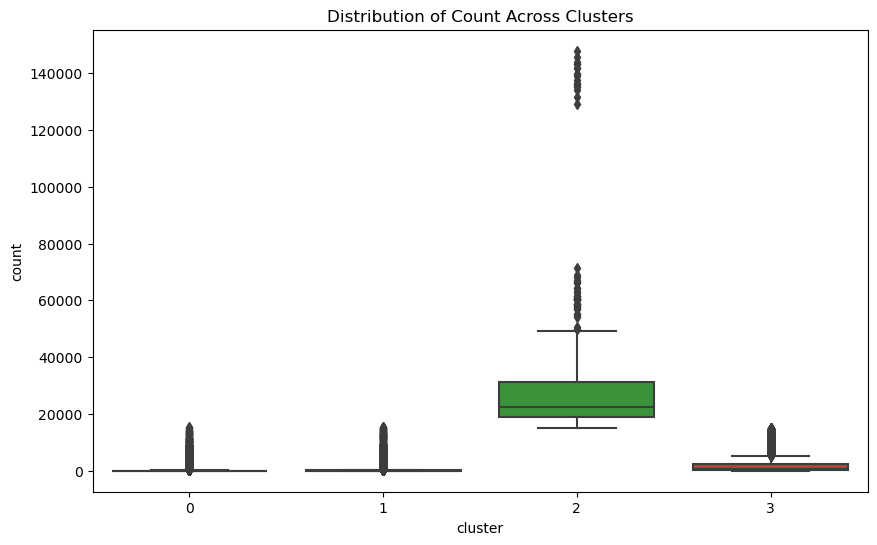

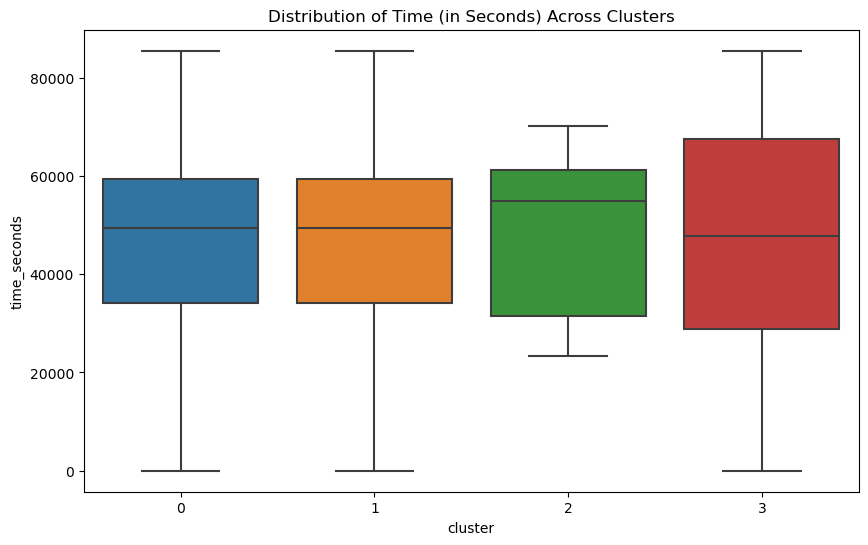

In [60]:
# Visualize distribution of 'count' across clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='count', data=df)
plt.title('Distribution of Count Across Clusters')
plt.show()

# Similarly, for other features like 'time_seconds'
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='time_seconds', data=df)
plt.title('Distribution of Time (in Seconds) Across Clusters')
plt.show()

**Cluster 0 and Cluster 1**:“Low Traffic - Off-Peak” and “Low Traffic - Consistent Low Usage”.<br>
**Cluster 2(“High Traffic - Peak Usage”)**: This cluster represents high traffic with significant variability.<br>
**Cluster 3(“Moderate Traffic - Steady Flow”)**: With moderate but steady traffic, this cluster.

**3.SUPERVISED LEARNING**

**3.1.Feature Engineering**

In [61]:
# Define target and features for supervised learning
target = df['count']
supervised_features = df[['time_seconds', 'loc_freq', 'paper_ticket_status', 'cluster'] + 
                         [col for col in df.columns if col.startswith('mode_') or col.startswith('tap_') or col.startswith('day_of_week_')]]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(supervised_features, target, test_size=0.2, random_state=42)

**3.2.Modeling :Random Forest Regressor**

I decided to use random forest for it'srobusteness, its ability to handle complex data, and it can provide insights of featire importance, it resists to overfitting and can handle outliers and missing data very well.

In [68]:
# Train a Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Perform grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Best Model Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

/Users/tresornoel/Desktop/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Model Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mean Squared Error: 1128166.5748519117
R^2 Score: 0.835971604037506


**3.3.Visualize model performance**

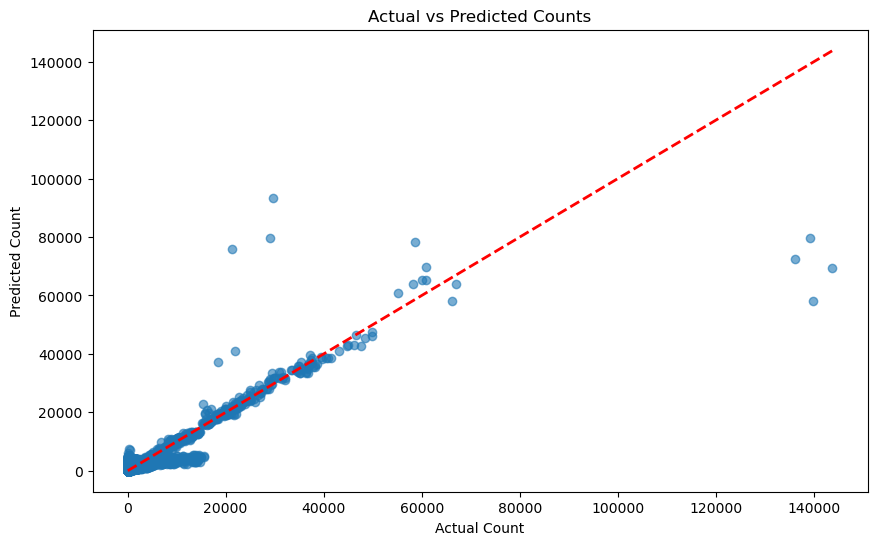

In [69]:
# Visualize the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.title('Actual vs Predicted Counts')
plt.show()

**3.4.Feature importance**

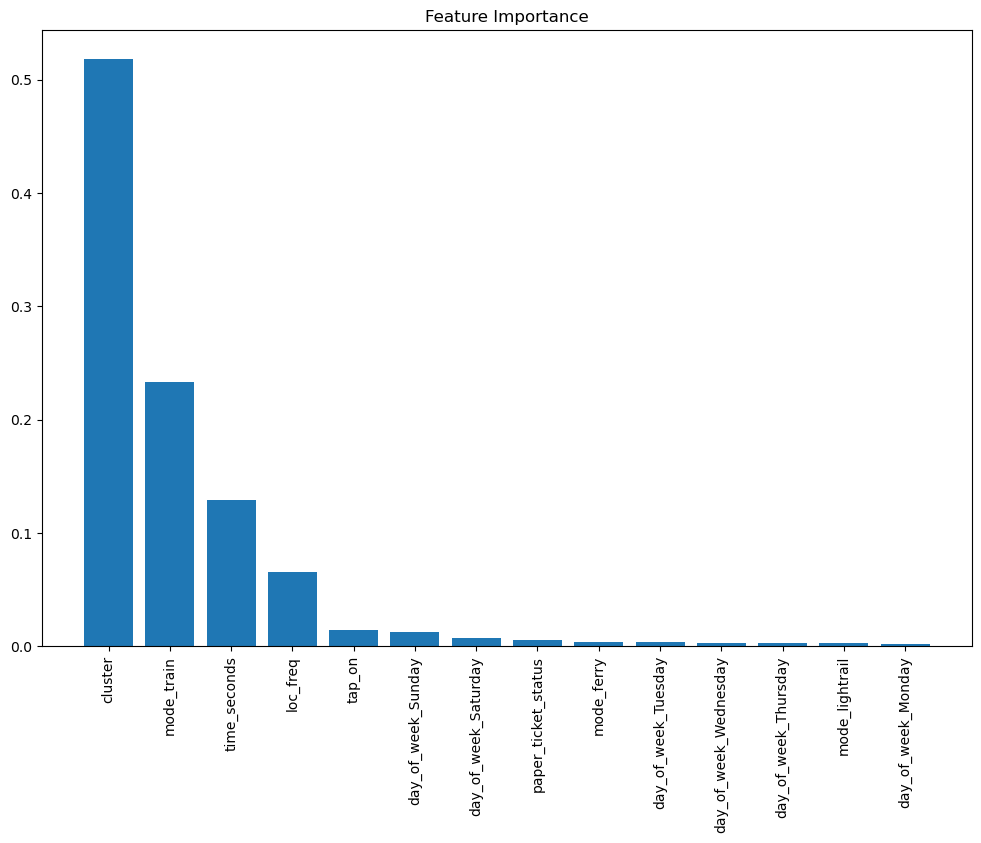

In [70]:
# Feature importance visualization
importances = best_rf_model.feature_importances_
feature_names = supervised_features.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.show()

**3.5.BaseLine Linear Regression Vs Random Forest**

Baseline Model MSE: 4754048.338348924
Baseline Model R²: 0.30879097054449256
Random Forest MSE: 1128166.5748519117
Random Forest R²: 0.835971604037506


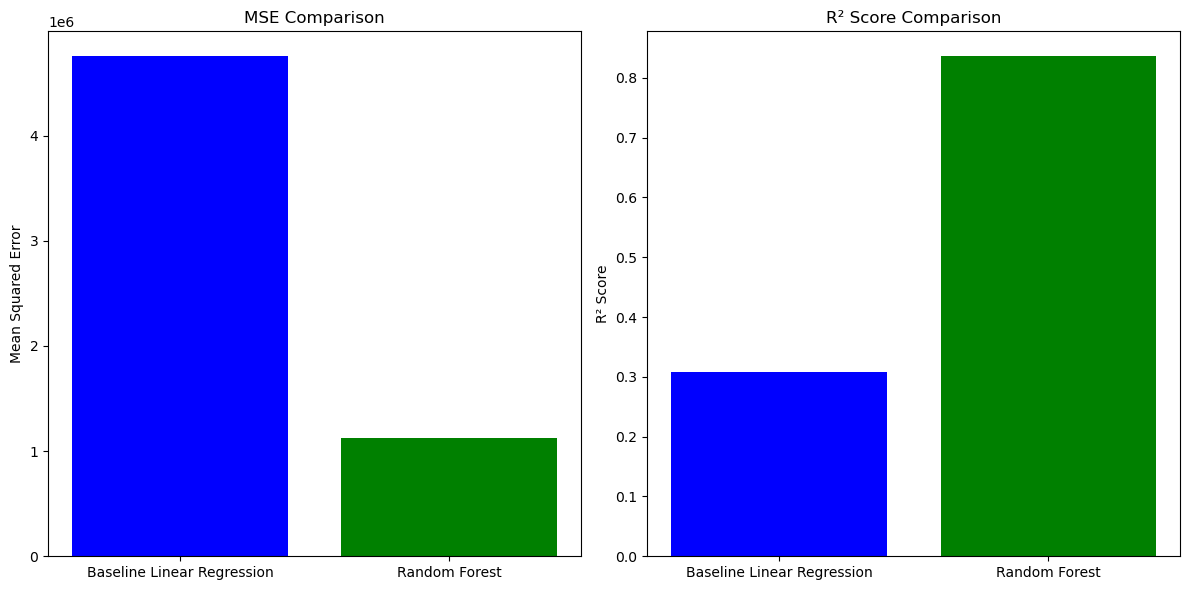

In [71]:
from sklearn.linear_model import LinearRegression

# Train a simple linear regression model as a baseline
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predict on test data
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate baseline model
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

# Compare with Random Forest results
print(f'Baseline Model MSE: {mse_baseline}')
print(f'Baseline Model R²: {r2_baseline}')

print(f'Random Forest MSE: {mse}')
print(f'Random Forest R²: {r2}')

# Comparison bar plot
labels = ['Baseline Linear Regression', 'Random Forest']
mse_values = [mse_baseline, mse]
r2_values = [r2_baseline, r2]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(labels, mse_values, color=['blue', 'green'])
plt.title('MSE Comparison')
plt.ylabel('Mean Squared Error')

plt.subplot(1, 2, 2)
plt.bar(labels, r2_values, color=['blue', 'green'])
plt.title('R² Score Comparison')
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

This code compares the performance of my advanced model (Random Forest) with a simpler baseline model (Linear Regression). The bar plots make it easier to see the value added by using a more sophisticated model

**3.6.Predictive Power Over Time**

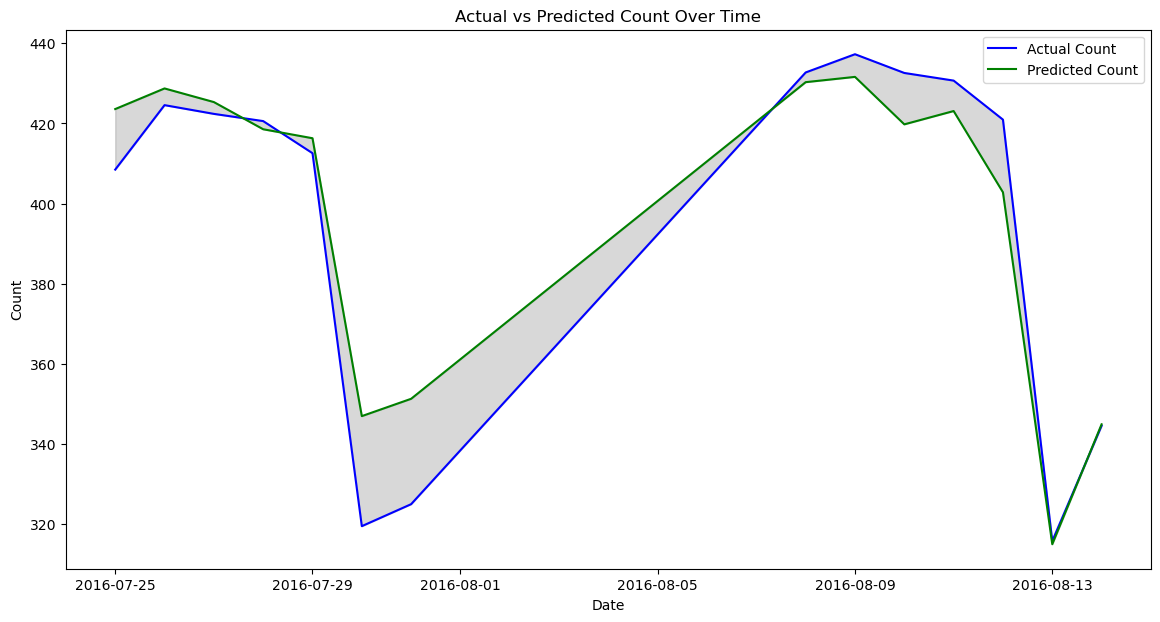

In [72]:
# Let's evaluate the model's performance over time
df['date'] = pd.to_datetime(df['date'])

# Group by date and calculate mean actual and predicted counts
df['predicted_count'] = best_rf_model.predict(supervised_features)
daily_performance = df.groupby('date').agg({'count': 'mean', 'predicted_count': 'mean'}).reset_index()

# Plot the actual vs predicted counts over time
plt.figure(figsize=(14, 7))
plt.plot(daily_performance['date'], daily_performance['count'], label='Actual Count', color='blue')
plt.plot(daily_performance['date'], daily_performance['predicted_count'], label='Predicted Count', color='green')
plt.fill_between(daily_performance['date'], daily_performance['count'], daily_performance['predicted_count'], color='gray', alpha=0.3)
plt.title('Actual vs Predicted Count Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.show()

This graph demonstrates the reliability of our model over time. As you can see, the predicted user counts (green line) align closely with the actual counts (blue line) across the timeline. The small discrepancies represented by the shaded area indicate that our model is consistently accurate, making it a valuable tool for forecasting demand and optimizing resource allocation in real-time